This notebook tests the simulation of harmonic acoustic pressure fields using the `pymust` library.

We will define transducer parameters, calculate the pressure field within specified boundaries, and visualize the resulting harmonic field.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pymust

In [2]:
param = pymust.getparam('P4-2v')
param.bandwidth = 20 # Toggle bandwidth limitation for faster simulation
param.attenuation = 0.5
xf = 0
zf = 5e-2
txdel= pymust.txdelay(xf, zf, param)
param.c = 1540

xbound = np.array([-4e-2,4e-2]) # in m
zbound = np.array([0,10e-2]) # in m


In [5]:
# Call the funcion
P1, SPECT_P1, IDX, f = pymust.harmonic.pfield(xbound, zbound, txdel, param)

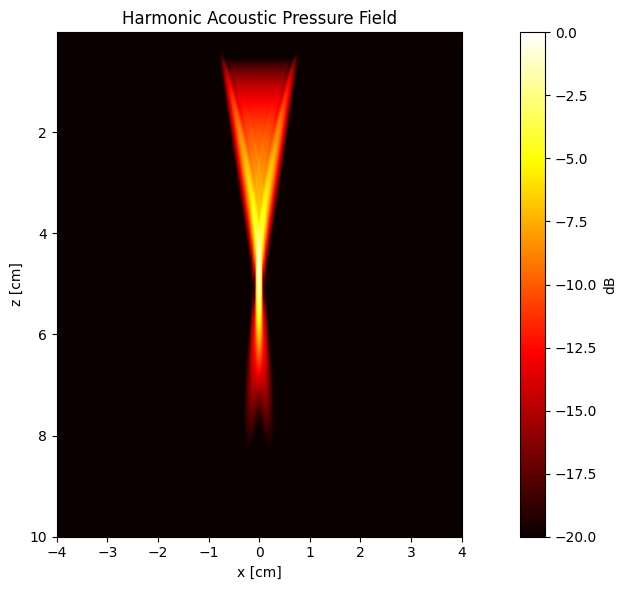

In [6]:
# Plot the results
def to_db(x):
    return 20*np.log10(np.abs(x)/(np.max(np.abs(x)) + 1e-10))

plt.figure(figsize=(12, 6))
extent_cm = [xbound[0]*100, xbound[1]*100, zbound[1]*100, zbound[0]*100]
plt.imshow(to_db(P1), cmap='hot', extent=extent_cm, aspect='auto')
plt.clim(-20, 0)
plt.colorbar(label='dB')
plt.xlabel('x [cm]')
plt.ylabel('z [cm]')
plt.title('Harmonic Acoustic Pressure Field')
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

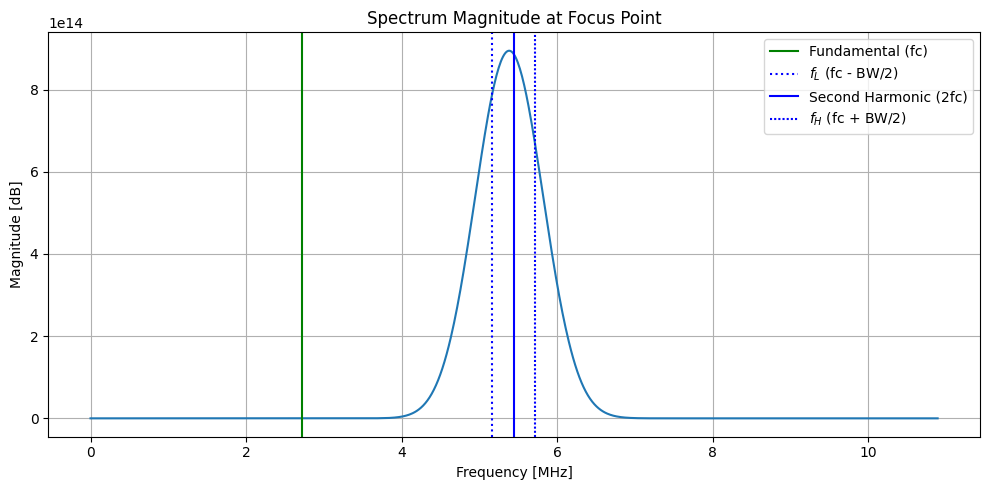

In [ ]:
f_reduced = f[IDX]

full_spectrum = np.zeros((SPECT_P1.shape[0], SPECT_P1.shape[1], IDX.shape[0]), dtype=complex)
full_spectrum[:, :, IDX] = SPECT_P1

z_cm = np.linspace(zbound[0]*100, zbound[1]*100, SPECT_P1.shape[0])

# Plot the magnitude of the spectrum at the focus point (xf, zf)
# Find the index in z closest to zf (in cm)
focus_z_idx = np.argmin(np.abs(z_cm - (zf * 100)))
# Use the central x index (already defined as central_x_idx)
central_x_idx = SPECT_P1.shape[1] // 2

spectrum_focus = full_spectrum[focus_z_idx, central_x_idx, :]

# Find the frequency indices for the lowest, central (2fc), and highest frequency in the harmonic bandwidth around 2fc
# param.bandwidth is in percent , so BW = param.fc * param.bandwidth / 100
fc = param.fc
BW = fc * param.bandwidth / 100
f_low = 2 * fc - BW / 2
f_high = 2 * fc + BW / 2

# Find the closest indices in f for these frequencies
f_reduced = f[IDX]
idx_low = np.argmin(np.abs(f_reduced - f_low))
idx_central = np.argmin(np.abs(f_reduced - 2 * fc))
idx_high = np.argmin(np.abs(f_reduced - f_high))

freqs = [f_reduced[idx_low], f_reduced[idx_central], f_reduced[idx_high]]
idxs = [idx_low, idx_central, idx_high]

plt.figure(figsize=(10, 5))
plt.plot(f / 1e6, np.abs(spectrum_focus))
plt.axvline(param.fc / 1e6, color='g', linestyle='-', label='Fundamental (fc)')
plt.axvline(f_reduced[idx_low] / 1e6, color='b', linestyle=":", label='$f_L$ (fc - BW/2)')
plt.axvline(f_reduced[idx_central] / 1e6, color='b', linestyle='-', label='Second Harmonic (2fc)')
plt.axvline(f_reduced[idx_high] / 1e6, color='b', linestyle=(0, (1, 1)), label='$f_H$ (fc + BW/2)')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Magnitude [dB]')
plt.title('Spectrum Magnitude at Focus Point')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

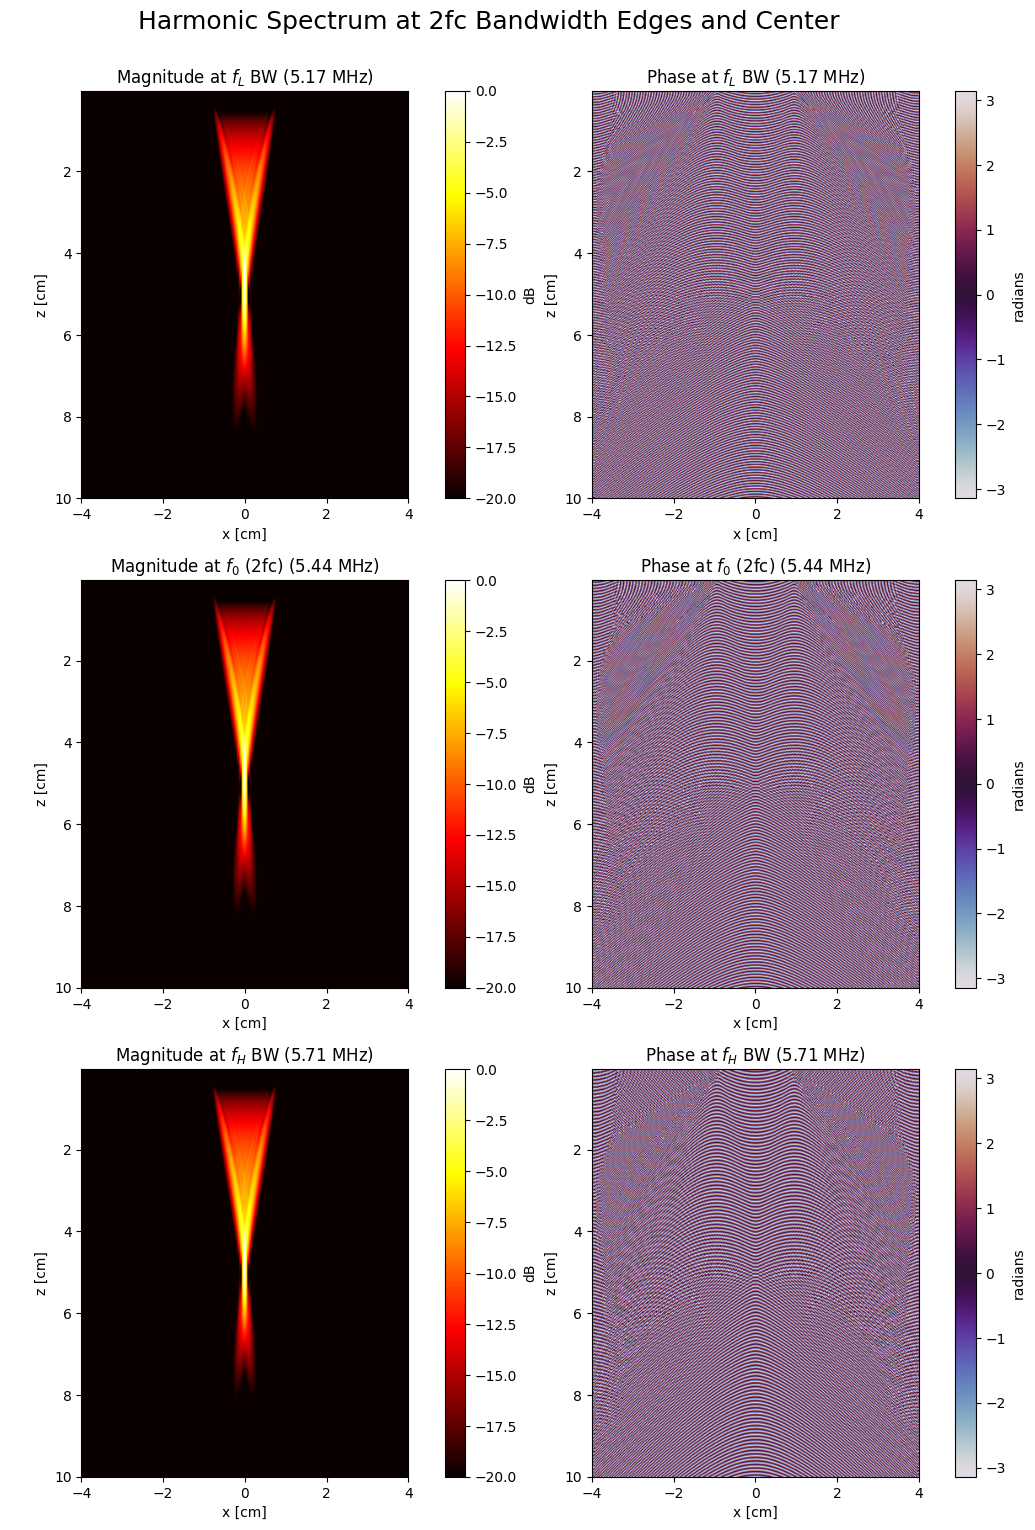

In [8]:
titles = [
    f'$f_L$ BW ({freqs[0]/1e6:.2f} MHz)',
    f'$f_0$ (2fc) ({freqs[1]/1e6:.2f} MHz)',
    f'$f_H$ BW ({freqs[2]/1e6:.2f} MHz)'
]

fig, axs = plt.subplots(3, 2, figsize=(16, 18))

for i, idx in enumerate(idxs):
    # Magnitude
    im_mag = axs[i, 0].imshow(
        20 * np.log10(np.abs(SPECT_P1[:, :, idx]) / np.max(np.abs(SPECT_P1[:, :, idx]))),
        cmap='hot', extent=extent_cm, aspect='auto'
    )
    axs[i, 0].set_title(f'Magnitude at {titles[i]}')
    axs[i, 0].set_xlabel('x [cm]')
    axs[i, 0].set_ylabel('z [cm]')
    axs[i, 0].set_aspect('equal', adjustable='box')
    im_mag.set_clim(-20, 0)
    fig.colorbar(im_mag, ax=axs[i, 0], label='dB')

    # Phase
    im_phase = axs[i, 1].imshow(
        np.angle(SPECT_P1[:, :, idx]),
        cmap='twilight', extent=extent_cm, aspect='auto'
    )
    axs[i, 1].set_title(f'Phase at {titles[i]}')
    axs[i, 1].set_xlabel('x [cm]')
    axs[i, 1].set_ylabel('z [cm]')
    axs[i, 1].set_aspect('equal')
    fig.colorbar(im_phase, ax=axs[i, 1], label='radians')

fig.subplots_adjust(wspace=-0.3, hspace=0.2)
fig.suptitle(f'{" "*15} Harmonic Spectrum at 2fc Bandwidth Edges and Center', fontsize=18, y=0.925)
plt.show()

## Faster implementation (WIP)

In [42]:
DR = 30  # Desired range in cm for the second harmonic field (faster computation)
P1_2, SPECT_P1_2, IDX_2, f_2 = pymust.harmonic.pfield(xbound, zbound, txdel, param, DR=DR)


In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(to_db(P1), cmap='hot', extent=extent_cm, aspect='auto')
plt.clim(-DR, 0)
plt.colorbar(label='dB')
plt.xlabel('x [cm]')
plt.ylabel('z [cm]')
plt.title('Harmonic Acoustic Pressure Field (Full)')
plt.gca().set_aspect('equal')

plt.subplot(1, 2, 2)
plt.imshow(to_db(P1_2), cmap='hot', extent=extent_cm, aspect='auto')
plt.clim(-DR, 0)
plt.colorbar(label='dB')
plt.xlabel('x [cm]')
plt.ylabel('z [cm]')
plt.title('Harmonic Acoustic Pressure Field (Reduced Range)')
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()

## Return of extra parameters

In [3]:
P1, SPECT_P1, IDX, f, extra_returns = pymust.harmonic.pfield(xbound, zbound, txdel, param, auxiliary_returns=["P0_SPECT", "linear_IDX"])
P0_SPECT = extra_returns["P0_SPECT"]
linear_IDX = extra_returns["linear_IDX"]

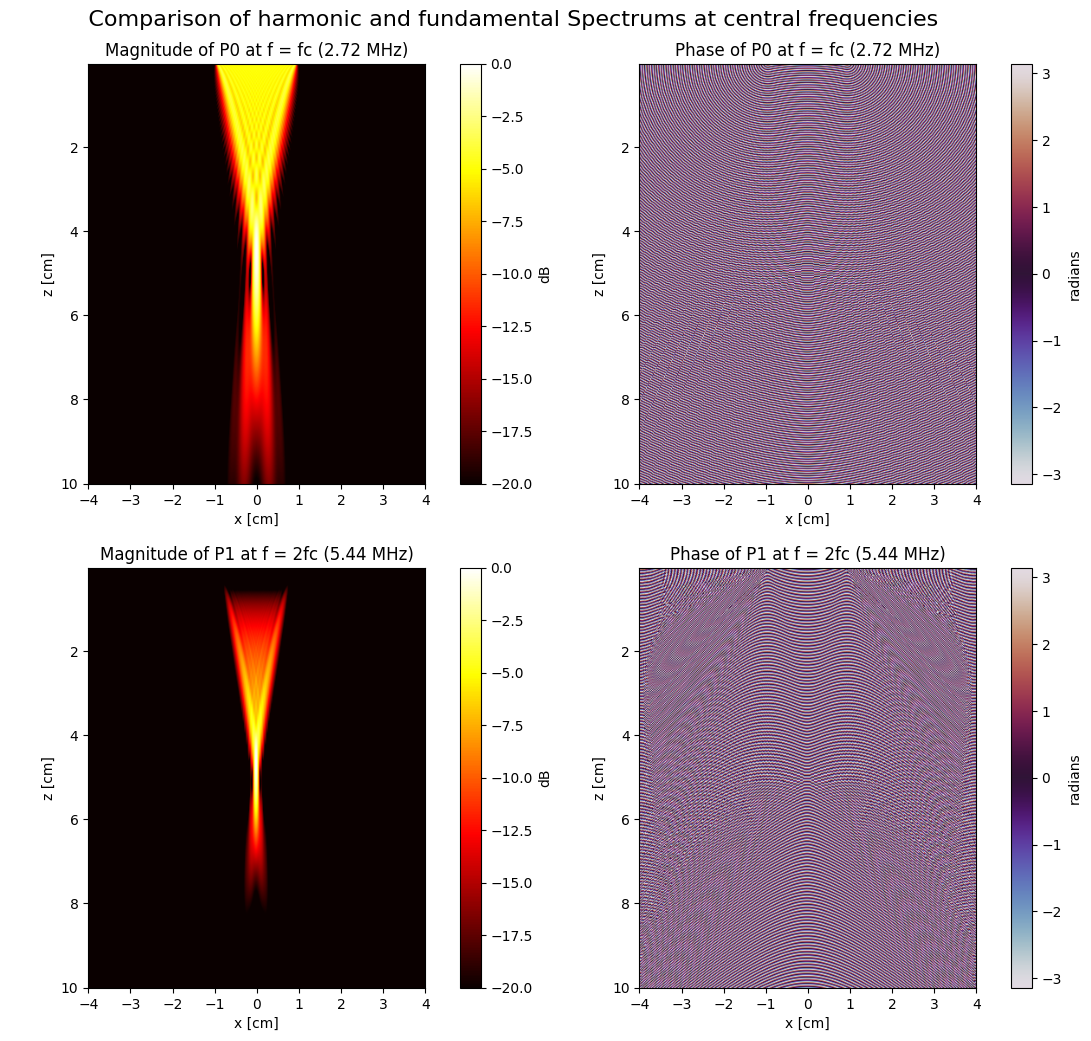

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
extent_cm = [xbound[0]*100, xbound[1]*100, zbound[1]*100, zbound[0]*100]
f_reduced = f[IDX]
idx_central = np.argmin(np.abs(f_reduced - 2 * param.fc))
f_P0 = param.f[linear_IDX]
fc_idx = np.argmin(np.abs(f_P0 - param.fc))

# Magnitude and phase for fc
im0 = axs[0, 0].imshow(
    20 * np.log10(np.abs(P0_SPECT[:, :, fc_idx]) / np.max(np.abs(P0_SPECT[:, :, fc_idx]))),
    cmap='hot', extent=extent_cm, aspect='auto'
)
axs[0, 0].set_title(f'Magnitude of P0 at f = fc ({f_P0[fc_idx]/1e6:.2f} MHz)')
axs[0, 0].set_xlabel('x [cm]')
axs[0, 0].set_ylabel('z [cm]')
axs[0, 0].set_aspect('equal', adjustable='box')
im0.set_clim(-20, 0)
fig.colorbar(im0, ax=axs[0, 0], label='dB')

im1 = axs[0, 1].imshow(
    np.angle(P0_SPECT[:, :, fc_idx]),
    cmap='twilight', extent=extent_cm, aspect='auto'
)
axs[0, 1].set_title(f'Phase of P0 at f = fc ({f_P0[fc_idx]/1e6:.2f} MHz)')
axs[0, 1].set_xlabel('x [cm]')
axs[0, 1].set_ylabel('z [cm]')
axs[0, 1].set_aspect('equal')
fig.colorbar(im1, ax=axs[0, 1], label='radians')

# Magnitude and phase for 2*fc
im2 = axs[1, 0].imshow(
    20 * np.log10(np.abs(SPECT_P1[:, :, idx_central]) / np.max(np.abs(SPECT_P1[:, :, idx_central]))),
    cmap='hot', extent=extent_cm, aspect='auto'
)
axs[1, 0].set_title(f'Magnitude of P1 at f = 2fc ({f_reduced[idx_central]/1e6:.2f} MHz)')
axs[1, 0].set_xlabel('x [cm]')
axs[1, 0].set_ylabel('z [cm]')
axs[1, 0].set_aspect('equal')
im2.set_clim(-20, 0)
fig.colorbar(im2, ax=axs[1, 0], label='dB')

im3 = axs[1, 1].imshow(
    np.angle(SPECT_P1[:, :, idx_central]),
    cmap='twilight', extent=extent_cm, aspect='auto'
)
axs[1, 1].set_title(f'Phase of P1 at f = 2fc ({f_reduced[idx_central]/1e6:.2f} MHz)')
axs[1, 1].set_xlabel('x [cm]')
axs[1, 1].set_ylabel('z [cm]')
axs[1, 1].set_aspect('equal')
fig.colorbar(im3, ax=axs[1, 1], label='radians')

fig.subplots_adjust(wspace=-0.2)
fig.suptitle(f'{" "*10} Comparison of harmonic and fundamental Spectrums at central frequencies', fontsize=16, y=0.925)
plt.show()